In [2]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

## We load the temperature data from the csv file and sort the data into matrices

In [49]:
class read_in_data(object):
    def __init__(self, filename):
        # Open the file
        fid_in = open(filename,"r")
        
        # The first line contains the headers
        dummy = fid_in.readline()
        
        timestamps = []
        depth      = []
        temp       = []
        fluo       = []
        
        # Loop through the file and store the data in the 
        # appropriate lists
        for dummy_line in fid_in:
            dummy_line = dummy_line.strip().split(",")

            date = datetime.strptime(dummy_line[1]+ " " +dummy_line[2], '"%m/%d/%y" "%H:%M:%S"')
            
            
            if dummy_line[3] == 'NA':
                continue
            else:
                timestamps.append(date)

                depth.append(float(dummy_line[3]))

                temp.append(float(dummy_line[4]))

                fluo.append(float(dummy_line[5]))
        
        fid_in.close()
        
        self.timestamps = np.array(timestamps)
        self.depth = np.array(depth)
        self.temp = np.array(temp)
        self.fluo = np.array(fluo)
    
        # Convert the timeseries into matrices 
        # It will involve a linear interpolation in the vertical
        self.vertical_consistency(dz = 0.2)
        
    def vertical_consistency(self, dz=0.2):
        
        # Initialize the lists linked to the matrices
        MTemp = []
        MDept = np.arange(0,self.depth.max()+dz,dz)
        MTime = []
        MFluo = []
        
        
        # The end of a profile will be marked by a smaller depth in the next index
        # Here we substract the neighbouring depth and check where it is megative
        # Assuming the first index in the time series is the beginning of a profile
        dep_diff = self.depth[1::] - self.depth[0:-1]
        
        # Where dep_diff <0 That's the end of a profile
        loc_end_prof = np.squeeze(np.where(dep_diff<0.))
  
        # Now we will loop through the indices we created to extract the profiles
        # It seems the profiler stops mid depth in between profiles, we will have 
        # to take this into account
        prof_start = 0
        

        for i in range(0,len(loc_end_prof),1):
            prof_end = loc_end_prof[i]+1
            
            profTime = self.timestamps[prof_start]
            profTemp = self.temp[prof_start:prof_end]
            profDept = self.depth[prof_start:prof_end]
            profFluo = self.fluo[prof_start:prof_end]
        
            # The instances when the profiler is mid depth, the profD should have
            # a length of 1. We don't focus on them, therefore, if we see one, we skip
            if len(profDept) <= 10:
                pass
            else:
                MTime.append(profTime)
                dummy_temp = np.interp(MDept, profDept, profTemp)
                MTemp.append(dummy_temp)
                
                dummy_fluo = np.interp(MDept, profDept, profFluo)
                MFluo.append(dummy_fluo)
            
            prof_start = prof_end # Beginning of next profile
            
        self.MTime = np.array(MTime)
        self.MTemp = np.array(MTemp)
        self.MDept = np.array(MDept)
        self.MFluo = np.array(MFluo)

temperature_data = read_in_data("WaterTempData/TeaIsland.csv")

In [42]:
temperature_data.MFluo.shape

(729, 142)

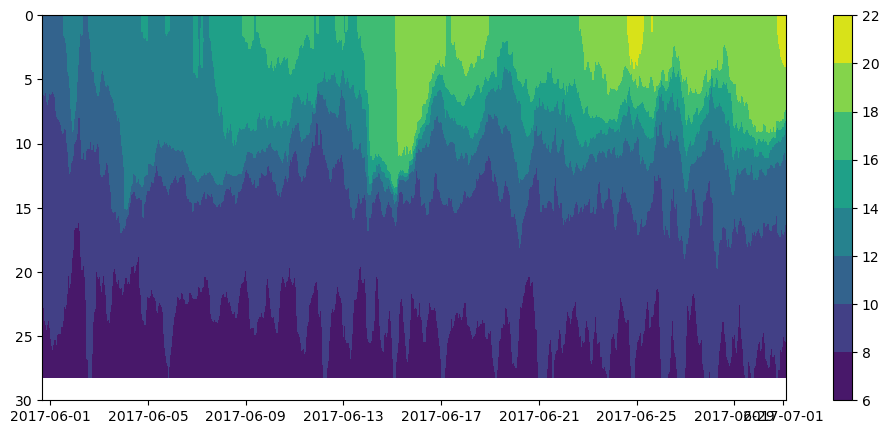

In [50]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
CS = ax.contourf(temperature_data.MTime, temperature_data.MDept, temperature_data.MTemp.T)
CB = plt.colorbar(CS)
ax.set_ylim((30,0))
plt.show()